In [37]:
# Import the libraries needed.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib 
import scipy 
import sklearn

from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path
import seaborn as sns
import statsmodels.api

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5] 



In [38]:
# run this function to check the stationarity of the dataset.

def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
        print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [39]:
# function to split the dataset, where test_split is the variable that will be the test size, e.g. 0.2.

def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [40]:
# read the dataset in, create a date column, index it and set to datetime.

df = pd.read_csv('/Users/paul.carroll/Github/Forecasting/data/weather.csv')
df['date'] = pd.to_datetime(df[['Day','Month','Year']])
df.set_index('date',inplace=True, drop=True)
df.head(2)

,Year,Month,Day,Hour,Minute,Temperature daily mean [2 m above gnd],Relative Humidity daily mean [2 m above gnd],Mean Sea Level Pressure daily mean [MSL],Total Precipitation (low resolution) daily sum [sfc],Total Cloud Cover daily mean [sfc],...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],Wind Speed daily max [900 mb],Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0,0,26.98,61.46,1006.71,2.1,69.88,...,100.0,0.0,5.13,0.08,7.88,0.17,18.62,1.00,12.30,4.03
2000-01-02,2000,1,2,0,0,24.44,82.12,1007.59,6.7,69.92,...,100.0,0.0,4.31,1.62,6.59,2.29,17.01,4.82,13.42,4.47


In [41]:
# renaming a few of the columns to make the names shorter and easier to reference. 

rename_map = {
   
    'Total Precipitation (low resolution) daily sum [sfc]':    'Rainfall',
    'Total Cloud Cover daily mean [sfc]':'Cloudcover',
   'Sunshine Duration daily sum [sfc]': 'Sunshine',
    'Temperature daily mean [2 m above gnd]':'Temperature',
    'Temperature daily max [2 m above gnd]':'Temperature_max',
    'Relative Humidity daily mean [2 m above gnd]':'Humidity',
    'Mean Sea Level Pressure daily mean [MSL]':'Pressure_mean',
    'Shortwave Radiation daily sum [sfc]':'Radiation',
     'Wind Speed daily max [900 mb]':'max_wind_speed',
    'Wind Speed daily mean [900 mb]':'Windspeed_mean'
}

df.rename(columns=rename_map, inplace=True)
df.head(2)

,Year,Month,Day,Hour,Minute,Temperature,Humidity,Pressure_mean,Rainfall,Cloudcover,...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],max_wind_speed,Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0,0,26.98,61.46,1006.71,2.1,69.88,...,100.0,0.0,5.13,0.08,7.88,0.17,18.62,1.00,12.30,4.03
2000-01-02,2000,1,2,0,0,24.44,82.12,1007.59,6.7,69.92,...,100.0,0.0,4.31,1.62,6.59,2.29,17.01,4.82,13.42,4.47


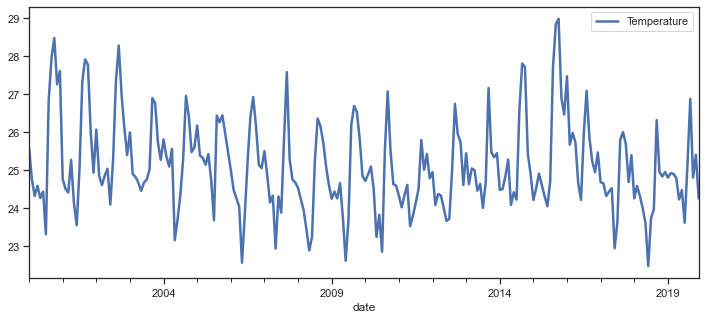

In [42]:
'''resampling the Temperature data monthly. 
Part of this analysis is to check the variable for outliers. In this case the variable looks rangebound with one spike at 29, 
only slightly above the other max of 28.5
'''
df.resample('M').mean()[['Temperature']].plot(lw=2.5,figsize=(12,5));

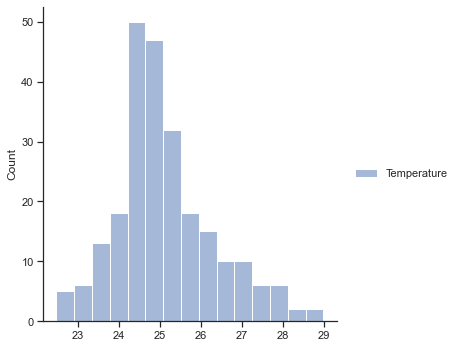

In [56]:
# And to double check on outliers, via checking the distribution of the variable Temperature. 
# In this case, the variable looks normally distributed with no outliers. 

sns.displot(df.resample('M').mean()[['Temperature']]);

In [44]:
# dropping 'Hour' and 'Minute' columns

df= df.drop(['Hour','Minute'],axis=1)

# Resampled the dataset to be monthly 

dfm = df.resample('M').mean()

In [57]:
# checking the stationarity of the variable Temperature, grouped monthly. In this case shown to be non-stationary.

check_stationarity(df.resample('M').mean()[['Temperature']])

('Non-Stationary', 0.09452412245146924)

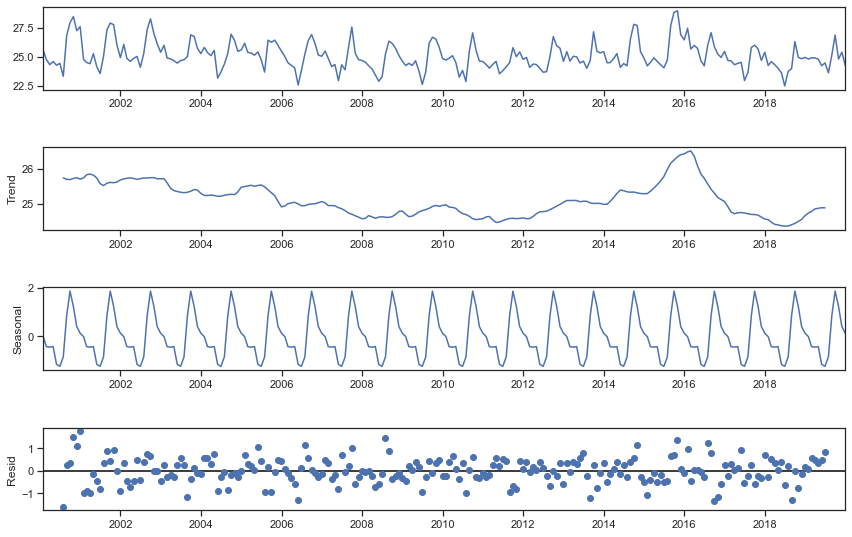

In [52]:
# using the seasonal decompose function in sklearn to analyse both trend and stationarity, and to look for any seasonal patterns in the data.

sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(df.resample('M').mean()[['Temperature']], period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();

In [65]:
# Differenced the dataset once to check stationarity again. Differenced by one, the dataset is now stationary. 
# What we have done is to remove the trend, visible in the seasonal decompose function on this variable, below. 

check_stationarity(dfm.Temperature.diff().dropna())

'Stationary	 p-value:9.58666174220612e-06 	 lags:13


('Stationary', 9.58666174220612e-06)

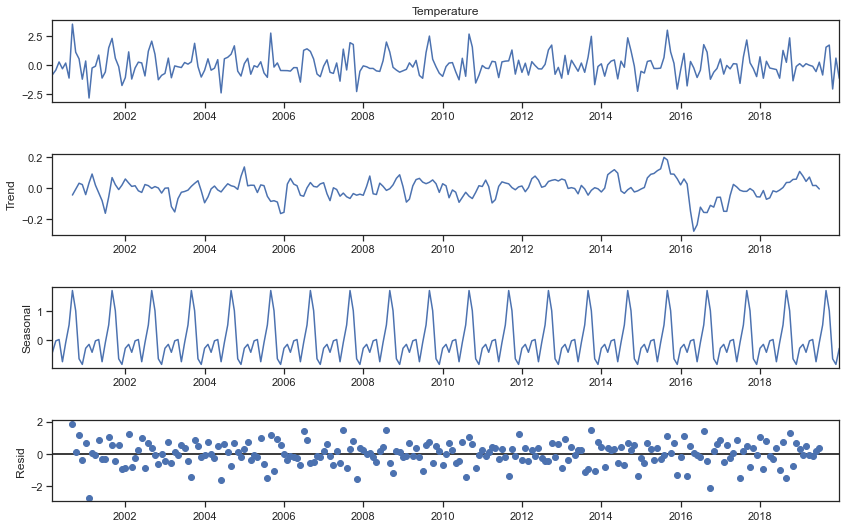

In [67]:
# using the seasonal decompose function in sklearn to re-analyse both trend and stationarity, and to look for any seasonal patterns in the data.

sns.set(style='ticks', rc={ "lines.linewidth":1.5})
decomposition = seasonal_decompose(dfm.Temperature.diff().dropna(), period=12)
fig = decomposition.plot()
fig.set_size_inches(12,8)
plt.show();

In [99]:
split_data(dfm.Temperature.diff().dropna(), 0.2)

train: 191 , test: 48


(date
 2000-02-29   -0.834638
 2000-03-31   -0.434394
 2000-04-30    0.265957
 2000-05-31   -0.321118
 2000-06-30    0.172452
                 ...   
 2015-08-31    3.004839
 2015-09-30    1.128817
 2015-10-31    0.146022
 2015-11-30   -2.076022
 2015-12-31   -0.442366
 Freq: M, Name: Temperature, Length: 191, dtype: float64,
 date
 2016-01-31    1.007097
 2016-02-29   -1.799099
 2016-03-31    0.307809
 2016-04-30   -0.244774
 2016-05-31   -1.075226
 2016-06-30   -0.441774
 2016-07-31    1.760484
 2016-08-31    1.109032
 2016-09-30   -1.227183
 2016-10-31   -0.622495
 2016-11-30   -0.295839
 2016-12-31    0.523903
 2017-01-31   -0.781290
 2017-02-28   -0.035184
 2017-03-31   -0.330622
 2017-04-30    0.116860
 2017-05-31    0.089591
 2017-06-30   -1.581258
 2017-07-31    0.699000
 2017-08-31    2.161613
 2017-09-30    0.196387
 2017-10-31   -0.316065
 2017-11-30   -0.998935
 2017-12-31    0.711194
 2018-01-31   -1.140323
 2018-02-28    0.326129
 2018-03-31   -0.257419
 2018-04-30   -0.3

Next for the analyis, is Autocorrelation and Partial Correlation analysis. 
What do these analyses tell you about the variable.

For ARIMA (SARIMAX by adding Seasonal) models, the model can be split into three parts. AR(p) is the AutoRegressive component of the model, MA(q) is the Moving Average part of the model. ARIMA combines the two, and adds in differencing for the middle part of the model parameters, (p,d,q).

p determines how far the model looks back at its past values, in order to estimate its current value. If p= 3, then you use three periods to predict current x. 

Partial Autocorrelation graphs can help to estimate the AR number, p. This works by estimating the effect of lags on the current variable, i.e. how much do past values influence current values. By plotting these and examining where the dots fall below and into the confidence interval, significance can be established. In the plots below, the PACF chart show three significant plots before the significance falls. From this, 0 can be the number interpreted for the p value. But there is significance between 2 and 12. Seasonality can be interpreted here too, from the spikes at 12, 24, 36. 

Autocorrelation plots, ACF, can be used to estimate the MA order. Using the same methodology in order to estimate the MA variable, q. 
In the example below there are 3 negative plots at 1, 2 and 3, before these return around 11,12,and 13. So q = 2, and again seasonality is interpreted, given the spikes at 12, 24, 36, etc. 




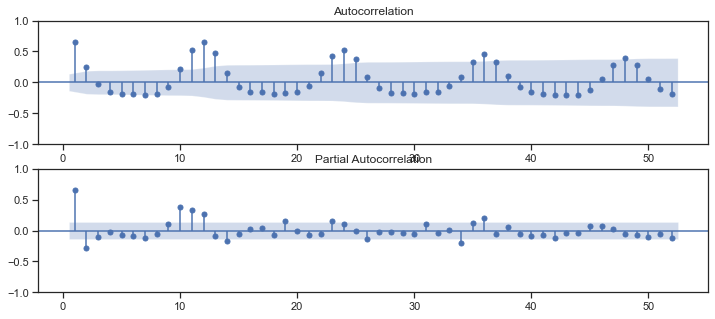

In [100]:
# Analysing the Autocorrelation and Partial Autocorrelation functions. 


fig, ax= plt.subplots(2,1)
plot_acf(train, zero=False,
         ax=ax[0], lags=52)
plot_pacf(train,zero=False,
          ax=ax[1], lags=52)
plt.show();



In [109]:
##fitting a seasonal ARIMA model, SARIMAX, with p, d, q as 2,1,2 and 12 as S.

# Plugging the values above into the model, we get p as 0, d as 1, and q as 2, s = 12

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(dfm.Temperature, order =(2,1,2), seasonal_order=(2,1,2,12)).fit(disp=False)



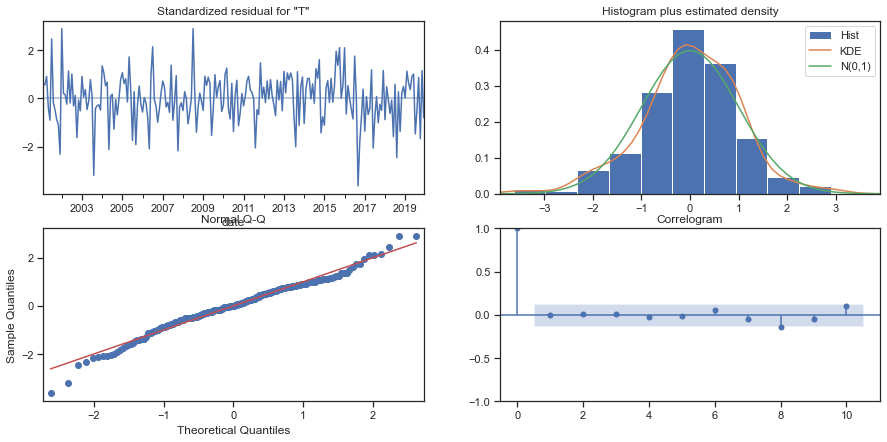

In [110]:
# Model diagnostics for visibility of residiuals, distribution, and the Q scores. 

model.plot_diagnostics(figsize=(15,7)); plt.show()

In [111]:
# Model summary function from the ARIMA library. Notice the BIC and AIC scores 

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                  240
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -237.207
Date:                            Thu, 29 Sep 2022   AIC                            492.413
Time:                                    10:47:02   BIC                            523.238
Sample:                                01-31-2000   HQIC                           504.852
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3946      0.964      0.409      0.682      -1.495       2.284
ar.L2          0.0687      0.375      0.183      0.855      -0.666       0.803
ma.L1         -0.9567      0.967     -0.989      0.322      -2.852       0.939
ma.L2          0.0336      0.879      0.038      0.969      -1.689       1.756
ar.S.L12      -0.6961      0.259     -2.684      0.007      -1.204      -0.188
ar.S.L24      -0.0584      0.102     -0.569      0.569      -0.259       0.143
ma.S.L12      -0.2164      1.285     -0.168      0.866      -2.735       2.302
ma.S.L24      -0.7736      1.124     -0.688      0.491      -2.976       1.429
sigma2         0.4017      0.523      0.768      0.442      -0.623       1.427
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.05
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.32
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The next section shows the Auto Arima function. 
This is a very useful function similar in function to Gridsearch, whereby the best parameters for the dataset can be identified.
Splitting the dataset into train and test, the function can then be applied with a min and max p, d, q, P, Q and the seasonal function set to True, with m set to 12, m in this case being months. 

In [164]:
from pmdarima.arima import auto_arima
import pmdarima as pm

In [165]:
train, test = pm.model_selection.train_test_split(dfm.Temperature,test_size=0.2)
print(f'Train: {train.size}')
print(f'Test: {test.shape}')

Train: 192
Test: (48,)


In [166]:
auto_m = pm.auto_arima(train, start_p = 0,start_q=0, max_P = 3, max_q = 3,
                       seasonal =True,
                       m = 12,
                       test = 'adf',
                       information_criterion = 'aic',
                       stepwise=True,
                       trace=True)
auto_m.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=627.707, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=483.079, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1785.840, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=538.618, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=475.961, Time=0.37 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=443.876, Time=0.90 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=467.513, Time=0.71 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=448.448, Time=0.85 sec
 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=445.278, Time=0.85 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=437.970, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  192
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 12)   Log Likelihood                -212.985
Date:                                 Thu, 29 Sep 2022   AIC                            437.970
Time:                                         12:23:38   BIC                            457.515
Sample:                                     01-31-2000   HQIC                           445.886
                                          - 12-31-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3402      1.269      2.632      0.008       0.853       5.828
ar.L1          0.4528      0.054      8.437      0.000       0.348       0.558
ar.S.L12       0.7570      0.085      8.903      0.000       0.590       0.924
ma.S.L12      -0.3098      0.121     -2.560      0.010      -0.547      -0.073
ma.S.L24       0.1137      0.085      1.339      0.181      -0.053       0.280
sigma2         0.4970      0.046     10.796      0.000       0.407       0.587
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.04
Prob(Q):                              0.99   Prob(JB):                         0.13
Heteroskedasticity (H):               0.80   Skew:                             0.24
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

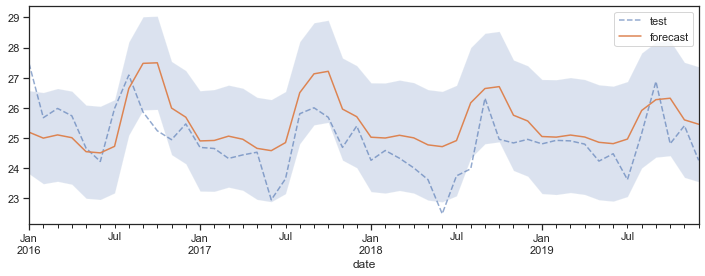

In [171]:
# the following code shows the model forecast alongside the test dataset for a visual graphical comparison. 

n = test.shape[0]
forecast, conf_interval = auto_m.predict(n_periods=n, return_conf_int=True)
lower_ci, upper_ci=zip(*conf_interval)
index = test.index
ax = test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast']); plt.show()

In [170]:
sum(forecast) == sum(conf_interval.mean(axis=1))

True

(3, 3)


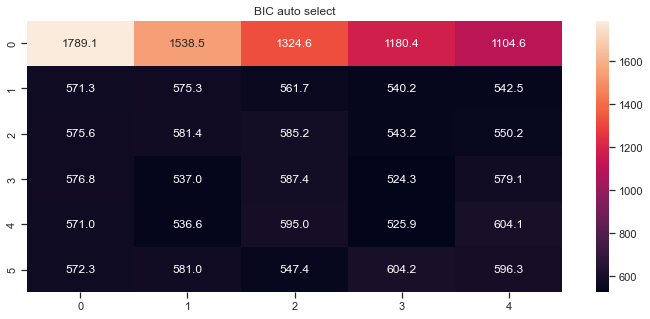

In [172]:
# The autoselect tool, below, can be used to identify optimal p and q for a dataset. Input the dataset, and parameters for max ar and max ma, 
# and read the grid for the lowest score. I've selected BIC, Bayesian information criterion as the min score. 
# All the 'bic' can easily be changed to 'aic' if that's what's needed for the modeling.

auto_select = sm.tsa.stattools.arma_order_select_ic(train, max_ar=5, max_ma=4, ic='bic', trend='n', model_kw={}, fit_kw={})

print(auto_select.bic_min_order)

sns.heatmap(auto_select['bic'], annot=True, fmt='.1f')
plt.ylim([auto_select['bic'].shape[0], 0])
plt.title('BIC auto select')
plt.show()


# The run here shows 3,3 as the optimal output for the model run. 

In [173]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [124]:
# This is a function designed to search through parameters as the tool above did. Here the parameters can be made wider, p and q up to any number your 
# computer can handle. Do note here that the function will at *3 will run 3 cubed models before outputting results. *4 or larger may stop your computer from
# from running any processes at all, due to ram. Mine stopped at *4. 

P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(3))]*3
vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P,D,Q) in enumerate(vals):
    if i%15 ==0:
        #print(f'Running model #(i) using SARIMA({p},{d},{q})({P},{D},{Q},12)')
        m = SARIMAX(train, order=(p,d,q),
                    seasonal_order = (P,D,Q,12),enforce_stationarity=False)
        res = m.fit(disp=0)
        y = train.values.ravel()
        y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q), 'seasonal order':(P,D,Q),
                    'AIC':res.aic,
                    'RMSPE': rmspe(y, y_hat),
                    'BIC': res.bic,
                    'AICc':res.aicc,
                    'RMSE' : rmse(y, y_hat),
                    'MAPE' : mape(y, y_hat),
                    'model': res}

In [127]:
# Another function to identify the best model. This time I've organised the model search by AIC.
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score=v[c]
            best_model = k
            print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [128]:
best_model = get_best_model(score,'AIC')

Best model: 15 with lowest AIC score: 447.9810077988656
Best model: 30 with lowest AIC score: 422.09430220958535
Best model: 45 with lowest AIC score: 367.1867836738364
Best model: 75 with lowest AIC score: 329.35107721919064
Best model: 615 with lowest AIC score: 321.70764657222253


In [129]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

,index,non-seasonal order,seasonal order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,626,"(2, 1, 2)","(0, 1, 2)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,618,"(2, 1, 1)","(2, 2, 0)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,619,"(2, 1, 1)","(2, 2, 1)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,620,"(2, 1, 1)","(2, 2, 2)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,621,"(2, 1, 2)","(0, 0, 0)",321.707647,1.628135,339.890274,322.282989,4.063443,0.144106,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


Following the univariate exploration of the SARIMAX model, it is also possible to look at exogenous (other) variables in a dataset to explore
how these relate to predicting Temperature from other variables in the wider dataframe.

Sarimax exogenous using other variables in the dataset. 
Here I've created a function to examine correlation between variables, in particular I'm looking for high numbers, either positive or negative correlation 
between Temperature and other variables.


In [130]:
def correlation_heat_map(df):
    corrs = np.round(df.corr(),decimals=2)*100
    fig, ax = plt.subplots(figsize=(20, 15))

   
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns.
    ax = sns.heatmap(corrs, mask=mask, annot=True,cmap='RdBu')

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, rotation=40)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)
    plt.show()

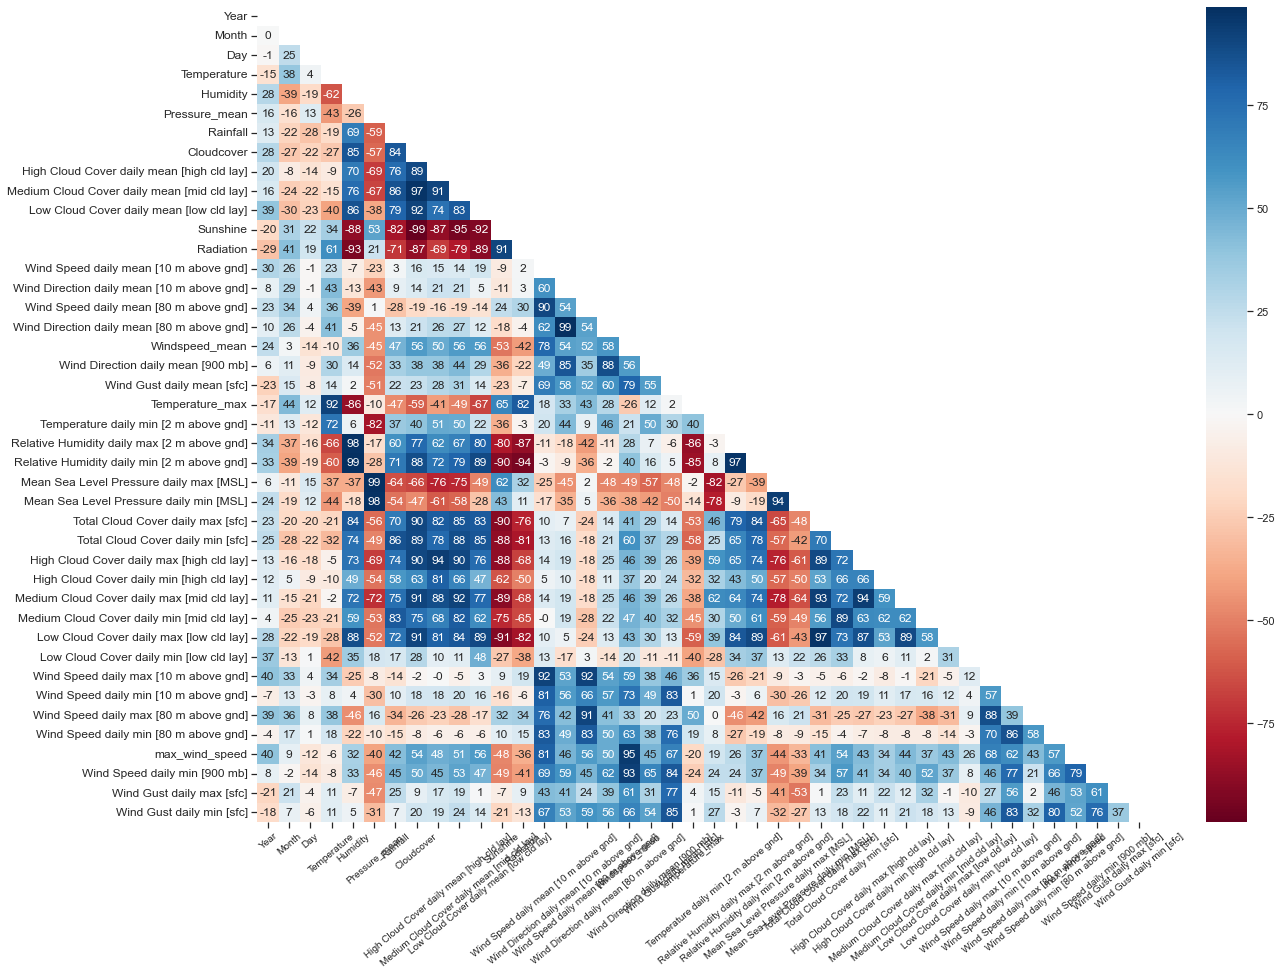

In [134]:
# Running the function on the monthly dataset. 
# Here I'm looking at Temperature on the x axis and trying to identify the variables on the x axis with the highest correlation scores. 

correlation_heat_map(dfm)

In [133]:
# Getting the column names, for copying these into the exogenous columns. 

dfm.columns

Index(['Year', 'Month', 'Day', 'Temperature', 'Humidity', 'Pressure_mean',
       'Rainfall', 'Cloudcover', 'High Cloud Cover daily mean [high cld lay]',
       'Medium Cloud Cover daily mean [mid cld lay]',
       'Low Cloud Cover daily mean [low cld lay]', 'Sunshine', 'Radiation',
       'Wind Speed daily mean [10 m above gnd]',
       'Wind Direction daily mean [10 m above gnd]',
       'Wind Speed daily mean [80 m above gnd]',
       'Wind Direction daily mean [80 m above gnd]', 'Windspeed_mean',
       'Wind Direction daily mean [900 mb]', 'Wind Gust daily mean [sfc]',
       'Temperature_max', 'Temperature daily min [2 m above gnd]',
       'Relative Humidity daily max [2 m above gnd]',
       'Relative Humidity daily min [2 m above gnd]',
       'Mean Sea Level Pressure daily max [MSL]',
       'Mean Sea Level Pressure daily min [MSL]',
       'Total Cloud Cover daily max [sfc]',
       'Total Cloud Cover daily min [sfc]',
       'High Cloud Cover daily max [high cld lay]',
    

In [135]:
# Here I've identified 5 variables all with extremely high correlation to Temperature. Radiation (93), Sunshine (-88), Relative Humidity daily max [2 m above gnd] (98),
# Relative Humidity daily min [2 m above gnd](99)', Low Cloud Cover daily max [low cld lay](88). 

exog_columns = [col for col in dfm.columns if '$' in col] + \
['Radiation','Sunshine','Relative Humidity daily max [2 m above gnd]','Relative Humidity daily min [2 m above gnd]','Low Cloud Cover daily max [low cld lay]',]

In [156]:
# Setting X as the 5 exogenous variables. 

X = dfm[['Sunshine', 'Radiation',
       'Relative Humidity daily max [2 m above gnd]',
       'Relative Humidity daily min [2 m above gnd]',
       'Low Cloud Cover daily max [low cld lay]', 'Temperature',
]]

In [157]:
# Setting y as the predictor variable.

y = dfm.Temperature

In [177]:
# running the model using the 2,1,2, 0,1,2 order from the suggested best model a few cells above. 

from statsmodels.tsa.statespace.sarimax import SARIMAX
period = 12
model_exog = SARIMAX(endog=dfm.Temperature, exog = X[['Radiation','Sunshine','Relative Humidity daily max [2 m above gnd]','Relative Humidity daily min [2 m above gnd]','Low Cloud Cover daily max [low cld lay]']],
                                       order = (1,1,2),
                                       seasonal_order = (0,1,2, period))

results_exog = model_exog.fit(maxiter=100)
results_exog.summary()
                                       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25908D-01    |proj g|=  5.44299D+01

At iterate    5    f=  8.22805D-01    |proj g|=  9.35686D+00

At iterate   10    f=  8.21638D-01    |proj g|=  3.38831D+00

At iterate   15    f=  8.20378D-01    |proj g|=  3.07921D+01

At iterate   20    f=  8.17326D-01    |proj g|=  1.07224D+00

At iterate   25    f=  8.16082D-01    |proj g|=  1.72269D+01

At iterate   30    f=  7.77195D-01    |proj g|=  4.11510D+01

At iterate   35    f=  7.73818D-01    |proj g|=  1.60909D+00

At iterate   40    f=  7.73816D-01    |proj g|=  1.88366D+00

At iterate   45    f=  7.73219D-01    |proj g|=  1.19451D+01

At iterate   50    f=  7.69353D-01    |proj g|=  2.09093D+00

At iterate   55    f=  7.63635D-01    |proj g|=  2.23816D+00

At iterate   60    f=  7.63278D-01    |proj g|=  9.11819D-01

At iterate   65    f=  7.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Temperature   No. Observations:                  240
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -177.155
Date:                            Thu, 29 Sep 2022   AIC                            376.310
Time:                                    12:28:43   BIC                            413.985
Sample:                                01-31-2000   HQIC                           391.513
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Radiation                                      -0.0004      0.000     -1.769      0.077      -0.001    4.53e-05
Sunshine                                        0.0037      0.001      2.495      0.013       0.001       0.007
Relative Humidity daily max [2 m above gnd]     0.0220      0.026      0.842      0.400      -0.029       0.073
Relative Humidity daily min [2 m above gnd]    -0.1362      0.031     -4.331      0.000      -0.198      -0.075
Low Cloud Cover daily max [low cld lay]         0.0206      0.005      4.422      0.000       0.011       0.030
ar.L1                                          -0.4308      0.684     -0.630      0.529      -1.772       0.910
ma.L1                                          -0.2738      0.677     -0.404      0.686      -1.601       1.054
ma.L2                                          -0.4101      0.501     -0.818      0.413      -1.393       0.572
ma.S.L12                                       -0.9127      0.106     -8.643      0.000      -1.120      -0.706
ma.S.L24                                       -0.0216      0.081     -0.268      0.789      -0.180       0.137
sigma2                                          0.2510      0.032      7.920      0.000       0.189       0.313
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                16.61
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.13
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The results summary above allow the user to examine how much these exogenous variables feed into predicting temperature, and how well they perform.
Here you're looking for the lowest std err figures, a p value less than 0.05. Here 4 of the variables perform well, Relative humidity....above gnd doesn't perform as well, suggesting selecting the 4 other variables and rerunning the model. It is worth trying this to achieve a lower AIC, BIC and better sigma2 number.